# Train Yolo Model

This notebook uses Ultralytics to train a YOLO model for object detection.
The base model was trained with various images captured from the CoppeliaSim simulator, allowing it to distinguish objects on the table, such as green cubes, colored cubes, red cubes, as well as other objects like spheres and the robot itself.
Currently, the dataset is not very large, consisting of only 40 images, but it is sufficient for detecting and performing pick-and-place tasks with the objects in the CoppeliaSim scene.

Now let's started to explain each steps.

## 1. Creation of the dataset

After takes some images from coppeliaSim. To create the dataset, it is possible to use software tools that allow you to generate images with labels and bounding boxes, such as [Roboflow](https://roboflow.com/) and [Label Studio](https://labelstud.io/).
after crreating the data, downloas file zip and ceate a yaml file with the follwoing code

## 2. pre set Yolo training

in this phase we have create a simple yolo training to create the models for our scope

**Verify NVIDIA GPU Availability and install requirments**

Make sure you're using a GPU machine. (much faster)
Click Play on the following code block to verify that the NVIDIA GPU is present and ready for training.
after is usefull to install the requiremnt (ultralytics)

In [91]:
!nvidia-smi
!pip install ultralytics

Mon Apr 28 14:20:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.83                 Driver Version: 566.50         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    On  |   00000000:01:00.0  On |                  N/A |
| N/A   39C    P8              2W /   80W |     519MiB /   8188MiB |      7%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import os
import shutil
import zipfile
import subprocess

notebook_dir = os.path.dirname(os.path.abspath("__file__"))

custom_data_path = os.path.join(notebook_dir, 'custom_dataset')
data_path = os.path.join(notebook_dir, 'data')
zip_file_path = os.path.join(notebook_dir, 'data.zip')
script_path = os.path.join(notebook_dir, 'train_val_split.py')

if os.path.exists(custom_data_path):
    shutil.rmtree(custom_data_path)

os.makedirs(custom_data_path, exist_ok=True)

# Estrai il contenuto dello zip nella nuova cartella
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(custom_data_path)


# Esegui train_val_split.py
subprocess.run(['python3', script_path, '--datapath', custom_data_path, '--train_pct', '0.9'])
print("Done!")





Created folder at /home/ruben/ws_workspaces/ws_CR/yolo_pipline_customdata/data/train/images.
Created folder at /home/ruben/ws_workspaces/ws_CR/yolo_pipline_customdata/data/train/labels.
Created folder at /home/ruben/ws_workspaces/ws_CR/yolo_pipline_customdata/data/validation/images.
Created folder at /home/ruben/ws_workspaces/ws_CR/yolo_pipline_customdata/data/validation/labels.
Number of image files: 24
Number of annotation files: 24
Images moving to train: 21
Images moving to validation: 3
Done!


In [ ]:
import os
notebook_dir = os.path.dirname(os.path.abspath("__file__"))

custom_data_path = os.path.join(notebook_dir, 'custom_dataset')
data_path = os.path.join(notebook_dir, 'data')
zip_file_path = os.path.join(notebook_dir, 'data.zip')
script_path = os.path.join(notebook_dir, 'train_val_split.py')
data_yaml_path = os.path.join(custom_data_path, 'data.yaml')
model_path = os.path.join(notebook_dir, 'yolo11s.pt')

In [93]:
import yaml
import os

def create_data_yaml(path_to_classes_txt, path_to_data_yaml, custom_data_dir):

    # Read classes.txt to get class names
    if not os.path.exists(path_to_classes_txt):
        print(f'classes.txt file not found! Please create a classes.txt labelmap and move it to {path_to_classes_txt}')
        return
    with open(path_to_classes_txt, 'r') as f:
        classes = [line.strip() for line in f.readlines() if line.strip()]
    number_of_classes = len(classes)

    # Create data dictionary
    data = {
        'path': data_path,
        'train': 'train/images',
        'val': 'validation/images',
        'nc': number_of_classes,
        'names': classes
    }

    # Write data to YAML file
    with open(path_to_data_yaml, 'w') as f:
        yaml.dump(data, f, sort_keys=False)
    print(f'Created config file at {path_to_data_yaml}')

# ----------- Qui sotto la parte principale ------------

# Definisci i percorsi relativi
path_to_classes_txt = os.path.join(custom_data_path, 'classes.txt')
path_to_data_yaml = os.path.join(custom_data_path, 'data.yaml')

# Esegui la funzione
create_data_yaml(path_to_classes_txt, path_to_data_yaml, custom_data_path)

# Stampa i contenuti del file YAML
with open(path_to_data_yaml, 'r') as f:
    print('\nFile contents:\n')
    print(f.read())


Created config file at /home/ruben/ws_workspaces/ws_CR/yolo_pipline_customdata/custom_dataset/data.yaml

File contents:

path: /home/ruben/ws_workspaces/ws_CR/yolo_pipline_customdata/data
train: train/images
val: validation/images
nc: 5
names:
- color_cube
- green_cube
- red_cube
- sphere
- robot



## 3. traning phase

## 3.1 Training Parameters (some theory)
**Model architecture & size (`model`):**
There are several YOLO11 model sizes available for training, including `yolo11n.pt`, `yolo11s.pt`, `yolo11m.pt`, `yolo11l.pt`, and `yolo11xl.pt`. Larger models offer higher accuracy but run slower, while smaller models are faster but less accurate. In our case, we use yolo11s.pt, which provides a good balance between training speed and performance.

**Number of epochs (`epochs`)**

In machine learning, one “epoch” is one single pass through the full training dataset. Setting the number of epochs dictates how long the model will train for. The best amount of epochs to use depends on the size of the dataset and the model architecture.


**Resolution (`imgsz`)**

Resolution has a large impact on the speed and accuracy of the model: a lower resolution model will have higher speed but less accuracy. YOLO models are typically trained and inferenced at a 640x640 resolution. However, if you want your model to run faster or know you will be working with low-resolution images, try using a lower resolution like 480x480.


In [ ]:
from ultralytics import YOLO

## 3.2 Run Training!

Run the following code block to begin training. If you want to use a different model, number of epochs, or resolution, change `model`, `epochs`, or `imgsz`.

In [ ]:


model = YOLO(model_path)

# Allena il modello
model.train(
    data=data_yaml_path,  # YAML dei dati
    epochs=60,            # Numero di epoche
    imgsz=640             # Dimensione immagini
)

print('Training completato!')


The training algorithm will parse the images in the training and validation directories and then start training the model. At the end of each training epoch, the program runs the model on the validation dataset and reports the resulting mAP, precision, and recall. As training continues, the mAP should generally increase with each epoch. Training will end once it goes through the number of epochs specified by `epochs`.

> **NOTE:** Make sure to allow training to run to completion, because an optimizer runs at the end of training that strips out unneeded layers from the model.

The best trained model weights will be saved in `content/runs/detect/train/weights/best.pt`. Additional information about training is saved in the `content/runs/detect/train` folder, including a `results.png` file that shows how loss, precision, recall, and mAP progressed over each epoch.

## 4. Test Model

The model has been trained; now it's time to test it! The commands below run the model on the images in the validation folder and then display the results for the first 10 images. This is a good way to confirm your model is working as expected. Click Play on the blocks below to see how your model performs.

In [ ]:
from ultralytics import YOLO
import os

# Percorsi relativi
validation_images_path = os.path.join(notebook_dir, 'data', 'validation', 'images')
new_model_path = os.path.join(notebook_dir, 'runs','detect','train','weights', 'best.pt')

# Carica il nuovo modello (dopo il training)
model = YOLO(new_model_path)

# Predici sulle immagini di validazione
results = model.predict(
    source=validation_images_path,
    save=True
)

print('Predizione completata con il nuovo modello!')



image 1/3 /home/ruben/ws_workspaces/ws_CR/yolo_pipline_customdata/data/validation/images/47bda262-Screenshot_2025-04-27_070057.png: 640x640 7 green_cubes, 55.6ms
image 2/3 /home/ruben/ws_workspaces/ws_CR/yolo_pipline_customdata/data/validation/images/5f8e748b-Screenshot_2025-04-14_210830.png: 576x640 5 red_cubes, 1 sphere, 72.3ms
image 3/3 /home/ruben/ws_workspaces/ws_CR/yolo_pipline_customdata/data/validation/images/d8d616c4-Screenshot_2025-04-14_210631.png: 544x640 1 color_cube, 2 green_cubes, 1 sphere, 53.4ms
Speed: 6.0ms preprocess, 60.4ms inference, 7.9ms postprocess per image at shape (1, 3, 544, 640)
Results saved to runs/detect/predict
Predizione completata con il nuovo modello!


here you can find the result about testing before 

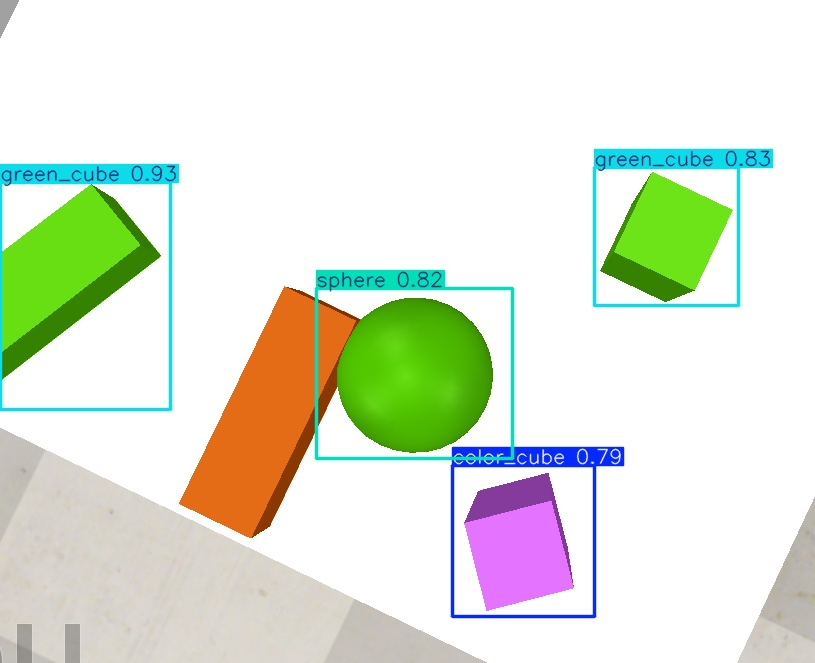

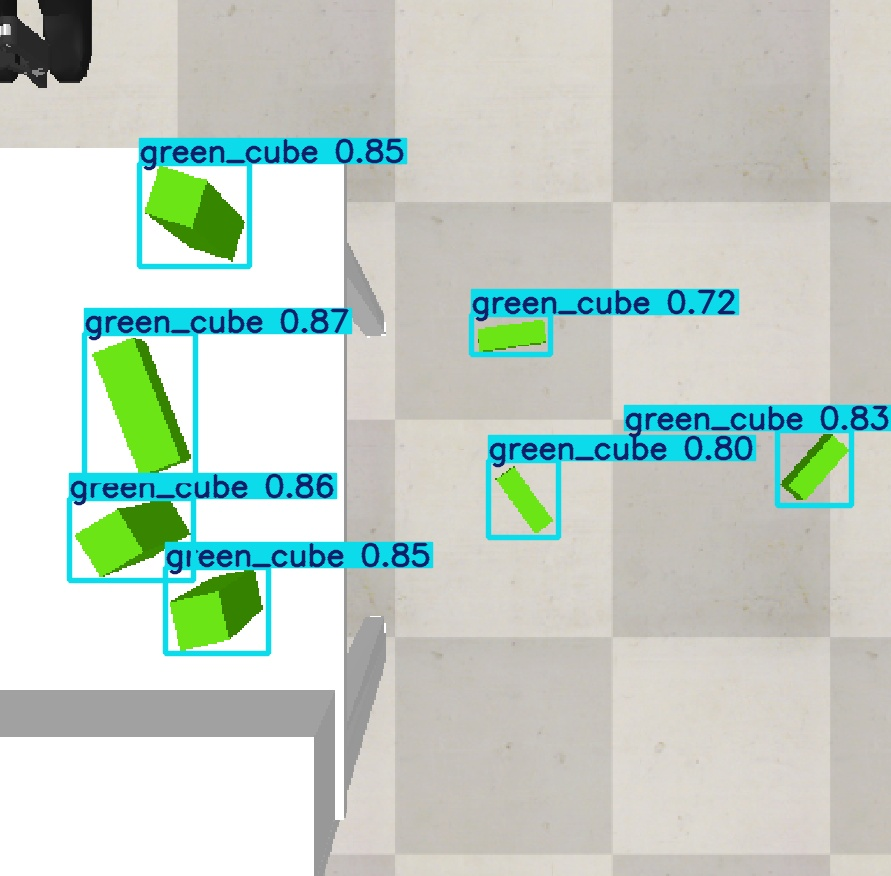

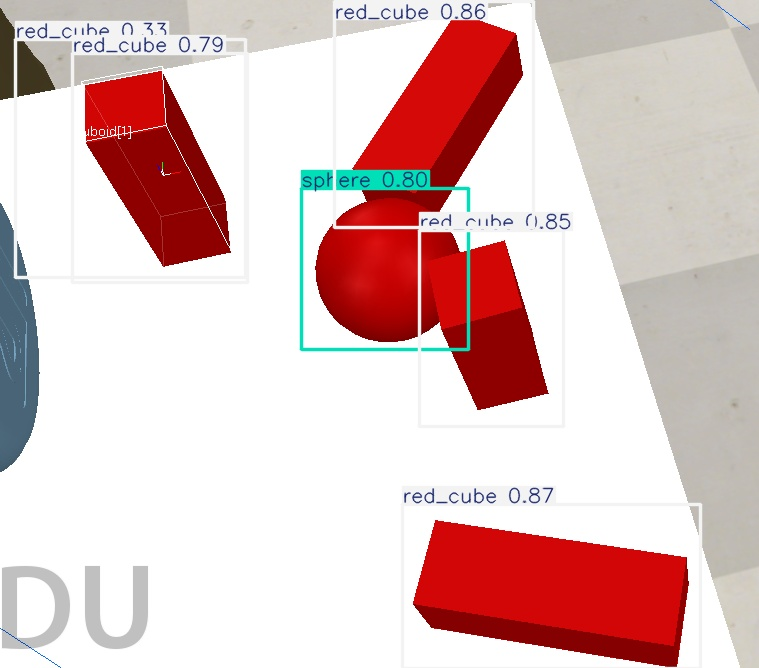

In [98]:
import glob
from IPython.display import Image, display
import os

predictions_folder = os.path.join(notebook_dir, 'runs', 'detect', 'predict')

for image_path in glob.glob(os.path.join(predictions_folder, '*.jpg'))[:10]:
    display(Image(filename=image_path, height=400))
    print('\n')


# 5. Deploy model
Now we are ready to import the trained model into our CoppeliaSim simulator and ROS2 environment. To do this, follow these steps:
`
1. Locate the best.pt file, which is saved in the `runs/detect/train/weights directory` after training.
2. Copy the best.pt file into the data folder of the `cr_vision` package.
3. Rename the file to `yolo_cubi.pt` to match the expected naming convention.
This will allow the model to be used for object detection tasks within the CoppeliaSim and ROS2 integration.